## How to reduce Random Forest memory consumption?

Random Forest algorithm from scikit-learn package can sometime consume too much memory:

 - https://datascience.stackexchange.com/questions/32644/randomforest-reasons-for-memory-usage-consumption
 - https://stackoverflow.com/questions/38141055/understanding-scikit-learn-random-forest-memory-requirement-for-prediction
 - https://stackoverflow.com/questions/23118309/scikit-learn-randomforest-memory-error
 - https://stackoverflow.com/questions/27777983/random-forest-running-out-of-memory
 - https://stackoverflow.com/questions/20413392/why-is-scikit-learns-random-forest-using-so-much-memory
 - https://stackoverflow.com/questions/53526382/memory-allocation-error-in-sklearn-random-forest-classification-python

The [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) have default hyper-parameters  `max_depth=None`, `min_samples_split=2` and `min_samples_leaf=1`, which means that full trees are built. Bulding full trees is by design (see Leo Breiman, [Random Forests](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf) article from 2001). The Random Forest creates full trees to fit the data well. If there will be one tree in the Random Forest, then it will overfit the data. However, in the Random Forest there are created set of trees (for example 100 trees). To overcome the overfitting (and increase stability) the bagging and random subspace sampling are used. (**Bagging** - selecting subset of rows for training, **random subspace sampling** - selecing subset of columns in each node split search).

In the case of large data sets or complex datasets, the full tree can be really deep and have thousands of nodes. 
The memory consumption of the Random Forest will grow very fast. In this post I will show how to reduce memory consumption of the Random Forest. I will use [Adult Income dataset](https://www.kaggle.com/wenruliu/adult-income-dataset).


### Let's load packages and data

In [132]:
import os
import joblib
import pandas as pd
import numpy as np
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from matplotlib import pyplot as plt

In [104]:
df = pd.read_csv("https://raw.githubusercontent.com/pplonski/datasets-for-start/master/adult/data.csv", 
                 skipinitialspace=True)

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [106]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [107]:
# Basic preprocessing
df = df.fillna(df.mode().iloc[0])
for col in df.columns:
    if df[col].dtype == "object":
        encode = LabelEncoder()
        df[col] = encode.fit_transform(df[col])

In [108]:
X = df[df.columns[:-1]]
y = df["income"]

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=56)

In [110]:
rf = RandomForestClassifier()

In [112]:
rf.fit(X_train, y_train)

RandomForestClassifier()

Check the depth of the first tree in the Random Forest

In [113]:

rf.estimators_[0].tree_.max_depth

41

In [119]:
depths = [tree.tree_.max_depth for tree in rf.estimators_]
print(f"Mean tree depth in the Random Forest: {np.round(np.mean(depths))}")

Mean tree depth in the Random Forest: 42.0


Text(0.5, 0, 'Depth to the tree in the Random Forest')

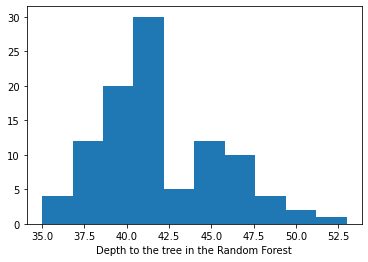

In [149]:
_ = plt.hist(depths)
plt.xlabel("Depth to the tree in the Random Forest")

Check the size of single tree:

In [129]:
joblib.dump(rf.estimators_[0], "first_tree_from_RF.joblib") 
print(f"Single tree size: {np.round(os.path.getsize('first_tree_from_RF.joblib') / 1024 / 1024, 2) } MB")

Single tree size: 0.52 MB


In [143]:
joblib.dump(rf, "RandomForest_100_trees.joblib") 
print(f"Random Forest size: {np.round(os.path.getsize('RandomForest_100_trees.joblib') / 1024 / 1024, 2) } MB")

Random Forest size: 49.67 MB


In [144]:
49.67 / 3.8

13.071052631578949

Before changing anything in the Random Forest let's check its performance.

In [164]:
y_predicted = rf.predict_proba(X_test)
rf_loss = log_loss(y_test, y_predicted)
print(rf_loss)

0.34350442620035054


The simplest way to reduce the memory consumption is to limit the depth of the tree.

In [137]:
shallow_rf = RandomForestClassifier(max_depth=6)

In [138]:
shallow_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6)

In [139]:
joblib.dump(shallow_rf.estimators_[0], "first_tree_from_shallow_RF.joblib") 
print(f"Single tree size from shallow RF: {np.round(os.path.getsize('first_tree_from_shallow_RF.joblib') / 1024 / 1024, 2) } MB")

Single tree size from shallow RF: 0.01 MB


In [154]:
joblib.dump(shallow_rf, "Shallow_RandomForest_100_trees.joblib") 
print(f"Shallow Random Forest size: {np.round(os.path.getsize('Shallow_RandomForest_100_trees.joblib') / 1024 / 1024, 2) } MB")

Shallow Random Forest size: 0.75 MB


In [155]:
49.67 / 0.75

66.22666666666667

In [206]:
y_predicted = shallow_rf.predict_proba(X_test)
shallow_rf_loss = log_loss(y_test, y_predicted)
print(shallow_rf_loss)

0.33017571925200956


In [207]:
(rf_loss-shallow_rf_loss) / shallow_rf_loss * 100.0

4.036852551888508

The shallow trees can be also obtained by setting `min_samples_split` or `min_samples_leaf` but for me they are not such intuitive as `max_depth` (that's why I prefer to set `max_depth`)

## Extra tip for saving the Scikit-Learn Random Forest in Python

While saving the scikit-learn Random Forest with joblib you can use compress parameter to save the disk space. In the joblib [docs](https://joblib.readthedocs.io/en/latest/generated/joblib.dump.html) there is information that `compress=3` is a good compromise between size and speed. Example below:

In [169]:
joblib.dump(rf, "RF_uncompressed.joblib", compress=0) 
print(f"Uncompressed Random Forest: {np.round(os.path.getsize('RF_uncompressed.joblib') / 1024 / 1024, 2) } MB")

Uncompressed Random Forest: 49.67 MB


In [171]:
joblib.dump(rf, "RF_compressed.joblib", compress=3)  # compression is ON!
print(f"Compressed Random Forest: {np.round(os.path.getsize('RF_compressed.joblib') / 1024 / 1024, 2) } MB")

Compressed Random Forest: 8.3 MB


In [173]:
np.round(49.67 / 8.3, 2)

5.98